In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        self.step_n += 1
        if self.step_n >= 200:
            done = True
        return state, reward, done, info


env = MyWrapper()

env.reset()

array([ 0.01897067, -0.04997724, -0.00336339, -0.018354  ], dtype=float32)

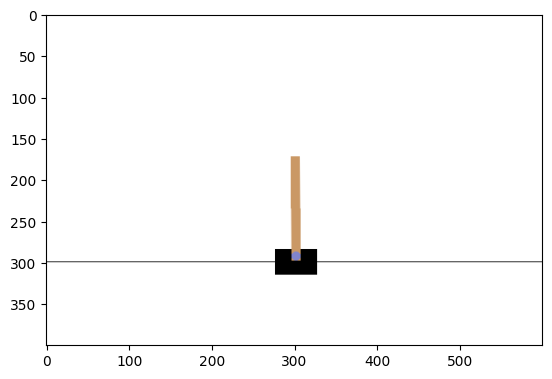

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline


#打印游戏
def show():
    plt.imshow(env.render())
    plt.show()


show()

In [79]:
import torch
import random


class ModelAction(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
                    torch.nn.Linear(4, 128),
                    torch.nn.ReLU(),
                    torch.nn.Linear(128, 2),
                    torch.nn.Softmax(dim=1),
                )

    def forward(self, state):
        prob = self.model(state)  # 输出概率 [1, 2]

        # 采样动作
        action = [random.choices(range(2), weights=p.tolist(), k=1)[0] for p in prob]  # 采样一个动作

        # 计算熵
        # prob[0, action] 是采样动作 action 的概率
        log_prob = torch.log(prob[0, action] + 1e-7)  # 避免 log(0) 加小 epsilon
        entropy = -log_prob  # 单个动作的熵贡献，-log π(a|s)

        # 或者更准确的熵估计（基于整个分布）
        # 熵 = -∑ π(a|s) log π(a|s)，可以使用 prob 直接计算期望
        #entropy = -torch.sum(prob * torch.log(prob + 1e-7))  # 整个分布的熵

        return action, entropy.reshape(-1,1)


model_action = ModelAction()

model_action(torch.randn(2,4))

([0, 1],
 tensor([[0.5062],
         [0.9233]], grad_fn=<ViewBackward0>))

In [80]:
class ModelValue(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(5, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 1),
        )

    def forward(self, state, action):
        #[b, 4+1] -> [b, 5]
        state = torch.cat([state, action], dim=1)

        #[b, 5] -> [b, 1]
        return self.sequential(state)


model_value1 = ModelValue()
model_value2 = ModelValue()

model_value_next1 = ModelValue()
model_value_next2 = ModelValue()

model_value_next1.load_state_dict(model_value1.state_dict())
model_value_next2.load_state_dict(model_value2.state_dict())

model_value1(torch.randn(2, 4), torch.randn(2, 1))

tensor([[-0.1072],
        [-0.0345]], grad_fn=<AddmmBackward0>)

In [81]:
import numpy as np


def get_action(state):
    state = torch.FloatTensor(state).reshape(1, 4)
    #[1, 4] -> [1, 2]
    action, _ = model_action(state)

    return action


get_action([1, 2, 3, 4])

[0]

In [93]:
#样本池
datas = []


### 改1：要收集足够多的数据
#向样本池中添加N条数据,删除M条最古老的数据
def update_data():
    old_count = len(datas)

    #玩到新增了N个数据为止
    while len(datas) - old_count < 200:
        #初始化游戏
        state = env.reset()

        #玩到游戏结束为止
        over = False
        while not over:
            #根据当前状态得到一个动作
            action = get_action(state)

            #执行动作,得到反馈
            next_state, reward, over, _ = env.step(action[0])

            #记录数据样本
            datas.append((state, action, reward, next_state, over))

            #更新游戏状态,开始下一个动作
            state = next_state

    update_count = len(datas) - old_count
    drop_count = max(len(datas) - 10000, 0)

    #数据上限,超出时从最古老的开始删除
    while len(datas) > 10000:
        datas.pop(0)

    return update_count, drop_count


update_data(), len(datas)

((206, 0), 206)

In [82]:
#获取一批数据样本
def get_sample():
    #从样本池中采样
    samples = random.sample(datas, 64)

    #[b, 4]
    state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 4)
    #[b, 1]
    action = torch.FloatTensor([i[1] for i in samples]).reshape(-1, 1)
    #[b, 1]
    reward = torch.LongTensor([i[2] for i in samples]).reshape(-1, 1)
    #[b, 4]
    next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 4)
    #[b, 1]
    over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)

    return state, action, reward, next_state, over


state, action, reward, next_state, over = get_sample()

state[:5], action[:5], reward[:5], next_state[:5], over[:5]

/tmp/ipykernel_450601/2486169052.py:11: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  reward = torch.LongTensor([i[2] for i in samples]).reshape(-1, 1)


(tensor([[ 0.0302,  0.6290, -0.0311, -1.0223],
         [ 0.0159,  0.0433, -0.0054, -0.1349],
         [ 0.0189, -0.1520, -0.0086,  0.1605],
         [ 0.0437, -0.3484, -0.0426,  0.4827],
         [ 0.1225,  1.2214, -0.1881, -2.0840]]),
 tensor([[0.],
         [1.],
         [1.],
         [0.],
         [0.]]),
 tensor([[1],
         [1],
         [1],
         [1],
         [1]]),
 tensor([[ 0.0428,  0.4344, -0.0516, -0.7396],
         [ 0.0168,  0.2385, -0.0081, -0.4292],
         [ 0.0159,  0.0433, -0.0054, -0.1349],
         [ 0.0367, -0.5429, -0.0330,  0.7616],
         [ 0.1469,  1.0286, -0.2298, -1.8549]]),
 tensor([[0],
         [0],
         [0],
         [0],
         [1]]))

In [90]:
from IPython import display


def test(play):
    #初始化游戏
    state = env.reset()

    #记录反馈值的和,这个值越大越好
    reward_sum = 0

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        state, reward, over, _ = env.step(action[0])
        reward_sum += reward

        #打印动画
        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


test(play=False)

16.0

In [73]:
def soft_update(model, model_next):
    for param, param_next in zip(model.parameters(), model_next.parameters()):
        #以一个小的比例更新
        value = param_next.data * 0.995 + param.data * 0.005
        param_next.data.copy_(value)


soft_update(torch.nn.Linear(4, 64), torch.nn.Linear(4, 64))

In [74]:
import math

#这也是一个可学习的参数
alpha = torch.tensor(math.log(0.01))
alpha.requires_grad = True

alpha

tensor(-4.6052, requires_grad=True)

In [83]:
def get_target(reward, next_state, over):
    #首先使用model_action计算动作和动作的熵
    #[b, 4] -> [b, 1],[b, 1]
    action, entropy = model_action(next_state)

    #评估next_state的价值
    #[b, 4],[b, 1] -> [b, 1]
    action_tensor = torch.tensor(action, dtype=torch.float32).reshape(-1,1)
    target1 = model_value_next1(next_state, action_tensor)
    target2 = model_value_next2(next_state, action_tensor)

    #取价值小的,这是出于稳定性考虑
    #[b, 1]
    target = torch.min(target1, target2)

    #exp和log互为反操作,这里是把alpha还原了
    #这里的操作是在target上加上了动作的熵,alpha作为权重系数
    #[b, 1] - [b, 1] -> [b, 1]
    target += alpha.exp() * entropy

    #[b, 1]
    target *= 0.99
    target *= (1 - over)
    target += reward

    return target


get_target(reward, next_state, over).shape

torch.Size([20, 1])

In [85]:
def get_loss_action(state):
    #计算action和熵
    #[b, 4] -> [b, 1],[b, 1]
    action, entropy = model_action(state)

    #使用两个value网络评估action的价值
    #[b, 4],[b, 1] -> [b, 1]
    action_tensor = torch.tensor(action, dtype=torch.float32).reshape(-1,1)
    value1 = model_value1(state, action_tensor)
    value2 = model_value2(state, action_tensor)

    #取价值小的,出于稳定性考虑
    #[b, 1]
    value = torch.min(value1, value2)

    #alpha还原后乘以熵,这个值期望的是越大越好,但是这里是计算loss,所以符号取反
    #[1] - [b, 1] -> [b, 1]
    loss_action = -alpha.exp() * entropy

    #减去value,所以value越大越好,这样loss就会越小
    loss_action -= value #图片公式里用了V，这里没用到

    return loss_action.mean(), entropy


get_loss_action(state)

(tensor(-0.0124, grad_fn=<MeanBackward0>),
 tensor([[0.6045],
         [0.6045],
         [0.6045],
         [0.7904],
         [0.6045],
         [0.6045],
         [0.6045],
         [0.7904],
         [0.7904],
         [0.7904],
         [0.7904],
         [0.7904],
         [0.6045],
         [0.7904],
         [0.7904],
         [0.7904],
         [0.7904],
         [0.7904],
         [0.6045],
         [0.6045]], grad_fn=<ViewBackward0>))

In [91]:
def train():
    optimizer_action = torch.optim.Adam(model_action.parameters(), lr=3e-4)
    optimizer_value1 = torch.optim.Adam(model_value1.parameters(), lr=3e-3)
    optimizer_value2 = torch.optim.Adam(model_value2.parameters(), lr=3e-3)

    #alpha也是要更新的参数,所以这里要定义优化器
    optimizer_alpha = torch.optim.Adam([alpha], lr=3e-4)

    loss_fn = torch.nn.MSELoss()

    #训练N次
    for epoch in range(100):
        #更新N条数据
        update_data()

        #每次更新过数据后,学习N次
        for i in range(200):
            #采样一批数据
            state, action, reward, next_state, over = get_sample()

            #对reward偏移,为了便于训练
            reward = (reward + 8) / 8

            #计算target,这个target里已经考虑了动作的熵
            #[b, 1]
            target = get_target(reward, next_state, over)
            target = target.detach()

            #计算两个value
            value1 = model_value1(state, action)
            value2 = model_value2(state, action)

            #计算两个loss,两个value的目标都是要贴近target
            loss_value1 = loss_fn(value1, target)
            loss_value2 = loss_fn(value2, target)

            #更新参数
            optimizer_value1.zero_grad()
            loss_value1.backward()
            optimizer_value1.step()

            optimizer_value2.zero_grad()
            loss_value2.backward()
            optimizer_value2.step()

            #使用model_value计算model_action的loss
            loss_action, entropy = get_loss_action(state)
            optimizer_action.zero_grad()
            loss_action.backward()
            optimizer_action.step()

            #熵乘以alpha就是alpha的loss
            #[b, 1] -> [1]
            loss_alpha = (entropy + 1).detach() * alpha.exp()
            loss_alpha = loss_alpha.mean()

            #更新alpha值
            optimizer_alpha.zero_grad()
            loss_alpha.backward()
            optimizer_alpha.step()

            #增量更新next模型
            soft_update(model_value1, model_value_next1)
            soft_update(model_value2, model_value_next2)

        if epoch % 10 == 0:
            test_result = sum([test(play=False) for _ in range(10)]) / 10
            print(epoch, len(datas), alpha.exp().item(), test_result)


train()

/tmp/ipykernel_450601/2486169052.py:11: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  reward = torch.LongTensor([i[2] for i in samples]).reshape(-1, 1)


0 51 0.008872825652360916 11.2
10 142 0.004899808205664158 9.3
20 232 0.0030080070719122887 9.5
30 327 0.001874864916317165 9.3
40 424 0.0012230564607307315 9.5
50 517 0.0008187643834389746 9.1
60 610 0.0005576490657404065 9.5
70 707 0.000384301645681262 9.3
80 801 0.0002663575578480959 9.4
90 896 0.00018733018077909946 9.3
